# Import libraries

In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import ipywidgets as widgets
from natsort import natsorted
import matplotlib.pyplot as plt
import seaborn as sns
from functions_metabodirect import *

currentDT = datetime.datetime.now()
print(currentDT.strftime("%Y-%m-%d %H:%M:%S %p"))
print(os.getcwd())

2021-02-03 11:46:15 AM
/Volumes/NGG_TFAILY_LAB_1/Fusarium_wilt_Lettuce/direct_injection/Water_fraction


In [2]:
project_name = 'MetaboDirect'
preprocess_dir = '1_preprocessing_output'
diagnostics_dir = '2_diagnostics'
metadata_filename = 'metadata.csv'

# Import necessary data

In [3]:
# import dataframe
path_data = os.path.join(project_name, preprocess_dir, 'Report_processed_MolecFormulas.csv')
df = pd.read_csv(path_data)

# import metadata
metadata = pd.read_csv(metadata_filename)

In [4]:
# get sample names in a list
samples = get_list_samples(df)

# append Mass and Error_ppm columns
samples.append('Mass')
samples.append('Error_ppm')

# subset
df = df[samples]

# melt - for grouping and plotting below
df = df.melt(id_vars = ['Mass', 'Error_ppm'], var_name = 'SampleID', value_name = 'NormIntensity')

# remove zeros
df = df[df['NormIntensity']>0].reset_index(drop=True)

# merge with metadata
df = df.merge(metadata, on='SampleID')

df.head()

,Mass,Error_ppm,SampleID,NormIntensity,Cultivar,Time,Treatment,Tissue,Rep,Names
0,202.108474,0.039455,Foc_1,0.002497,Fungus,7 dpi,Fungus,Fungus,1,Fungus 7 dpi
1,206.154991,0.227248,Foc_1,0.000592,Fungus,7 dpi,Fungus,Fungus,1,Fungus 7 dpi
2,206.982546,0.180962,Foc_1,0.000595,Fungus,7 dpi,Fungus,Fungus,1,Fungus 7 dpi
3,208.097895,0.105159,Foc_1,0.000589,Fungus,7 dpi,Fungus,Fungus,1,Fungus 7 dpi
4,209.081945,-0.061504,Foc_1,0.000582,Fungus,7 dpi,Fungus,Fungus,1,Fungus 7 dpi


# Mean predicted formula per sample

In [8]:
# group by SampleID and Names, and count the number of m/z present in each sample
# group by SampleID to get the error bar in the bar plot below
stats_per_sample = pd.DataFrame(df.groupby(['SampleID', 'Names'])[['Mass']].size()).rename(columns={0:'Counts'})
stats_per_sample = stats_per_sample.reset_index()

# save
filename = os.path.join(project_name, diagnostics_dir , 'stats_formula_per_sample.csv')
stats_per_sample.to_csv(filename, index=False)

In [22]:
sample_id = natsorted(list(stats_per_sample['Names'].unique()))

selector = widgets.SelectMultiple(
    options=sample_id,
    disabled=False
)

print('Select sample(s) to display below:')

display(selector)

Select sample(s) to display below:


SelectMultiple(options=('Fungus 7 dpi', 'Susceptible leaf healthy 7 dpi', 'Susceptible leaf healthy 10 dpi', '…

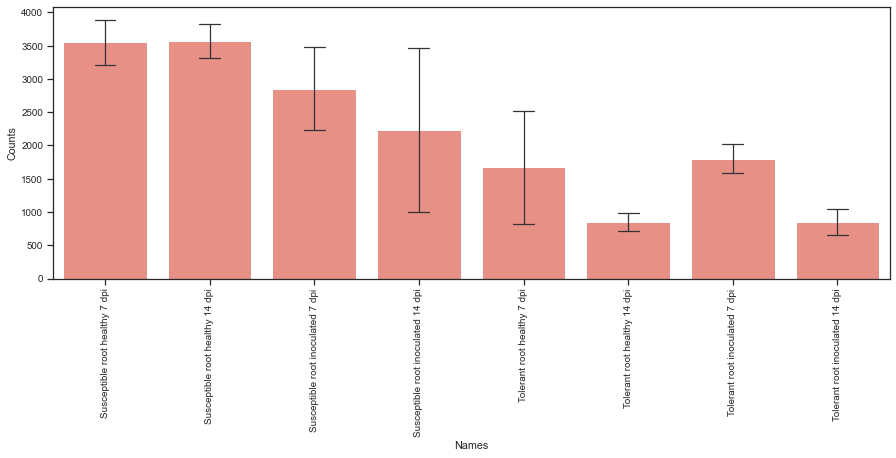

In [23]:
sns.set_theme(style="white")
sns.set(font_scale=0.9)
sns.set_style("ticks")
plt.rcParams['figure.figsize'] = (15,5)

samples_selected = natsorted(list(selector.value))

p = sns.barplot(x="Names",
                 y="Counts",
                 data=stats_per_sample,
                 order=samples_selected,
                 color="salmon",
                 saturation=0.7,
                 errcolor='.2',
                 ci="sd",
                 capsize=0.2,
                 errwidth = 1.25)

plt.setp(p.get_xticklabels(), rotation=90);

# save
filename = os.path.join(project_name, diagnostics_dir , 'stats_formula_per_sample.png')
plt.savefig(filename, dpi = 300, bbox_inches="tight")

# Error distribution per sample

In [25]:
subset = df.groupby(['Names', 'Mass'])['Error_ppm'].agg(['mean']).reset_index()

# save
filename = os.path.join(project_name, diagnostics_dir , 'error_distribution_per_sample.csv')
subset.to_csv(filename, index=False)

In [26]:
sample_id = natsorted(list(subset['Names'].unique()))

selector = widgets.SelectMultiple(
    options=sample_id,
    disabled=False
)

print('Select sample(s) to display below:')

display(selector)

Select sample(s) to display below:


SelectMultiple(options=('Fungus 7 dpi', 'Susceptible leaf healthy 7 dpi', 'Susceptible leaf healthy 10 dpi', '…

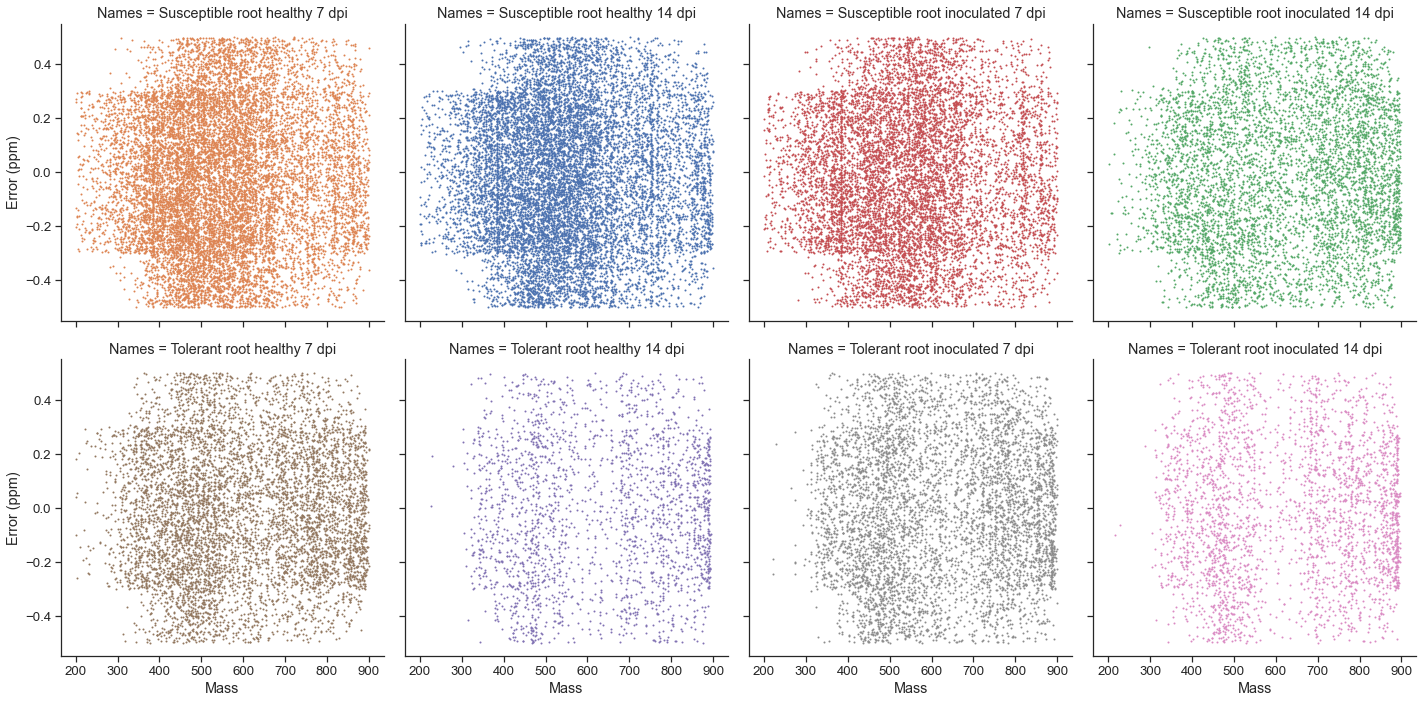

In [31]:
sns.set_theme(style="white")
sns.set(font_scale=1.2)
sns.set_style("ticks")
# plt.rcParams['figure.figsize'] = (15,5)

samples_selected = natsorted(list(selector.value))
cols = int(len(samples_selected) / 2)

subset = subset[subset['Names'].isin(samples_selected)]

grid = sns.FacetGrid(subset,
                     col="Names",
                     hue="Names",
                     col_wrap=cols,
                     col_order=samples_selected,
                     height=5)

grid.map(plt.scatter, "Mass", "mean", s=1)
grid.set_axis_labels(y_var="Error (ppm)")


# save
filename = os.path.join(project_name, diagnostics_dir , 'error_distribution_per_sample.png')
plt.savefig(filename, dpi = 300, bbox_inches="tight")